# BM25

In [1]:
import os
import sys
import math
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
def word_cloud(text: list):
  """text: list of text documents/sentences"""
  text = [str(i) for i in text]
  text = ' '.join(text).lower()
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()


# embedding

In [3]:
class BM25():
  """
  data: list of strings
  token_len: avg | min | max | avg_max[avg of avg and max]
  freq_sat - frequency_saturation : float
  len-norm - length of normalisation : float
  token_len - tokens length per document ot have same length in all docs
  """
  def __init__(self, data: list, freq_sat=0.2, len_norm=2, tokens_len='avg'):
    self.data = data
    self.freq_sat = freq_sat
    self.len_norm = len_norm
    self.tokens_len = tokens_len.lower()
    # used for filling short documents to make documents have equal lengths
    self.special_token: float = np.finfo(np.float32).eps # sys.float_info.epsilon # use the
    self.normalise_data()
  
  def normalise_data(self): self.data = [ str(doc).lower() for doc in self.data ]

  def TF(self, t, d):
    f = self.freq_term_document(t, d)
    n = f * self.freq_saturation()
    dd = f + (self.freq_sat * ( 1 - self.len_norm + self.len_norm * ( self.len_doc(d) / self.avg_doc_length() )))
    return n / dd
  
  def freq_saturation(self,): return self.freq_sat + 1
  
  def len_doc(self, d): return len( d.split(" ") )
  
  def avg_doc_length(self,): 
    return sum( [ len(d.split(" ")) for d in self.data ] ) / self.__len__()
  
  def freq_term_document(self, t, d): return d.split(" ").count(t)
  
  def IDF(self, t):
    n = self.__len__() - self.numb_doc_with_term(t) + .5
    d = self.numb_doc_with_term(t) + .5
    y = np.log((n/d)+1)
    return y

  def transform(self):
    """ variant, modified to fit my use case """
    res = []
    for doc in self.data: 
      x = [ self.TF(t, doc) * self.IDF(t) for t in doc.split(" ") ]
      res.append(x)
    res = self._token_length(res)
    return res

  def numb_doc_with_term(self, t):
    c = 0;
    for doc in self.data: 
      if t in doc: c += 1
    return c
  
  def len_document(self, d): 
    return len(d.split(" "))
  
  def __len__(self): return len(self.data)
  
  def _token_len_min(self):
    return min([len(i.split(' ')) for i in self.data])
  
  def _token_len_max(self):
    return max([len(i.split(' ')) for i in self.data])
  
  def _token_len_avg(self):
    return round(sum( [len(d.split(' ')) for d in self.data] ) / len(self.data))
  
  def _vocabulary(self):
    '''
    - store unique words from the entire document
    - store vocab using their bm25, so that its can be easily to map back from bm25 number to word used
    '''
    pass
  
  def _vocabulary_length(self):
    '''get the length of unique words from the data corpus'''
    x = ' '.join(self.data)
    x = ' '.join(x.split()).lower().split(' ')
    return len(set(x))
    
  def _token_length(self, embs ):
    tl = []
    tlen = 0
    # 
    if self.tokens_len == 'min': tlen = self._token_len_min()
    elif self.tokens_len == 'max': tlen = self._token_len_max()
    elif self.tokens_len == 'avg_max': tlen = math.ceil( (self._token_len_max() + self._token_len_avg() ) / 2 )
    else : tlen = self._token_len_avg()
    # 
    for d in embs:
      if len(d) < tlen: d.extend( [ self.special_token for _ in range(len(d), tlen)])
      else: d = d[: tlen]
      tl.append(d)
      
    return tl

# data

In [4]:
train = pd.read_csv("./data/train.csv")
train.head()

,label,text,targets
0,positive,im getting on borderlands and i will murder yo...,1
1,positive,i am coming to the borders and i will kill you...,1
2,positive,im getting on borderlands and i will kill you all,1
3,positive,im coming on borderlands and i will murder you...,1
4,positive,im getting on borderlands 2 and i will murder ...,1


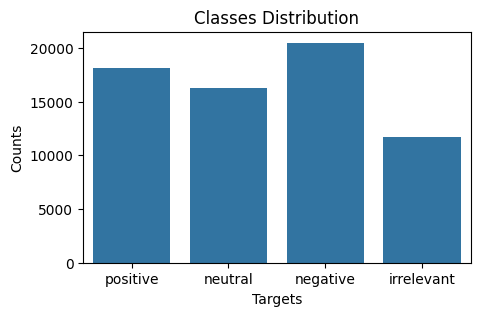

In [5]:
plt.figure(figsize=(5, 3))
sns.countplot(data=train, x ='label')
plt.ylabel("Counts")
plt.xlabel("Targets")
plt.title("Classes Distribution")
plt.show()

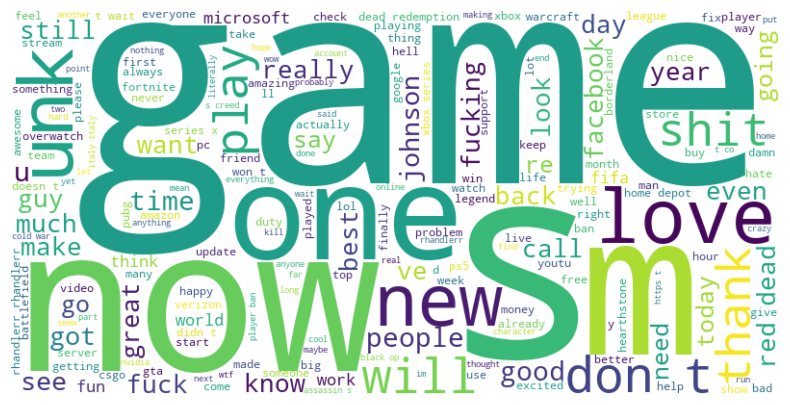

In [6]:
x = list( train['text'].values )
word_cloud(x)

# TF-IDF

In [11]:
x = list(train['text'].values)
len(x)

66569

In [10]:
vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(x)

feature_names = vectorizer.get_feature_names_out()

print(tfidf_matrix.toarray().shape)



(66569, 30168)


# BM25

# Val